# Advanced Map Widget Useage

This guide covers more advanced uses for the map widget: see [using the map widget](../using-the-map-widget) for more information!

## Property Updating

The map widget handles `zoom`, `tilt`, `heading`/`rotation`, `basemap`, `center`, `extent`, etc. features in an interesting and powerful way. Try running the below cells to gain insight into how these properties are updated:


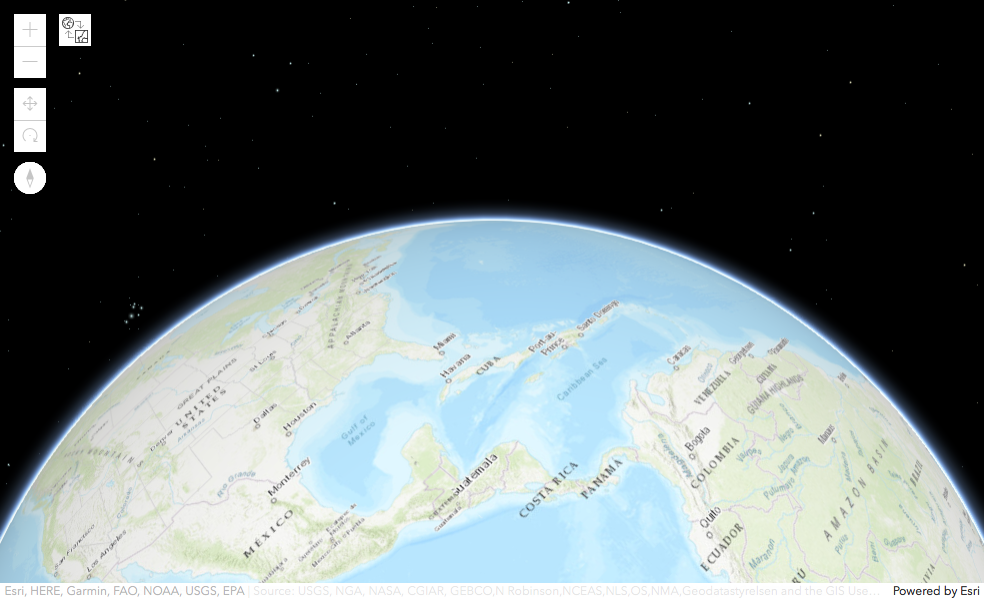

In [18]:
from arcgis.gis import GIS

def print_map_info(map):
    print("Mode =\t\t{}".format(map.mode))
    if map.mode == "2D":
        print("Zoom =\t\t{}\n".format(map.zoom) + \
              "Rotation =\t{}".format(map.rotation))
    elif map.mode == "3D":
        print("Zoom =\t\t{}\n".format(map.zoom) + \
              "Tilt =\t\t{}\n".format(map.tilt) + \
              "Heading =\t{}".format(map.heading))
    else:
        raise Exception("Not supported argument")

usa_map = GIS().map("USA")
usa_map.mode = "3D"
usa_map

In [3]:
print_map_info(usa_map)

Mode =		3D
Zoom =		1.3856049324356938
Tilt =		0.13085251425698102
Heading =	8.537736462515939e-07


Now, using your mouse, move the map to a new location, zoom in, modify the tilt and heading, etc. After you've move the camera, run the below cell to print out the current state of those properties:

In [4]:
print_map_info(usa_map)

Mode =		3D
Zoom =		4.057564184135124
Tilt =		8.446352685544214
Heading =	15.599097870716443


The values of those python variables have changed when you moved around in the widget! Experiment with printing out the values of `center`, `extent`, and any of the above properties. See the API reference for more information.

Then, try clicking on this icon on the upper left corner of the widget:

<img src=" 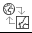"> 

You'll notice that you've switched from 3D mode to 2D mode! All properties, including `map.mode` have been updated! Try running the below cell to see what your current values are:

In [5]:
print_map_info(usa_map)

Mode =		2D
Zoom =		4.0
Rotation =	344.40090214146767


You can always click the icon on the upper left corner to switch between 2D and 3D mode. The widget will do it's best to preserve your current view.

# Callbacks

You can setup an asyncronous callback using the `on_click()` or `on_draw_end()` to create dynamic, interactive 'apps'. You need to create a callback function like `function_name(map_inst, geometry)`, with `map_inst` being the `MapView` instance, and `geometry` being the geometry instance that the user clicked.

The below example takes a point a user clicks on the map, reverse geocodes from the geometry, and prints out the resultant location. Also to note here, you can either create the GIS connection using existing profile, or by simply entering the username and password, e.g. `gis = GIS("https://www.arcgis.com", "arcgis_python", "P@ssword123")`.


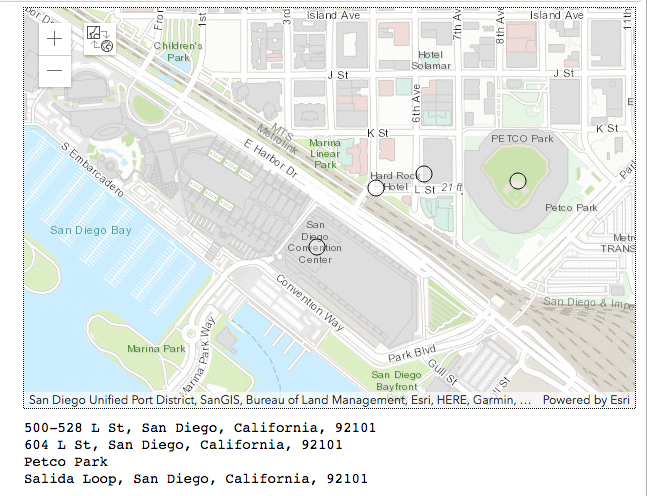

In [14]:
from arcgis.gis import GIS
import arcgis.geocoding as geocoding
gis = GIS(profile = "your_online_profile")
callback_map = gis.map('San Diego convention center, San Diego, CA', 16)
def find_addr(callback_map, g):
    try:
        callback_map.draw(g)
        geocoded = geocoding.reverse_geocode(g)
        print(geocoded['address']['Match_addr'])
    except:
        print("Couldn't match address. Try another place...")
callback_map.on_click(find_addr)
callback_map

# 3D Feature Layers

Let's create a new map of Zion National Park in Utah. 3D mode will show the elevation of the many canyons, rides, and elevation changes. It will even cast shadows. Run the below cell and explore!


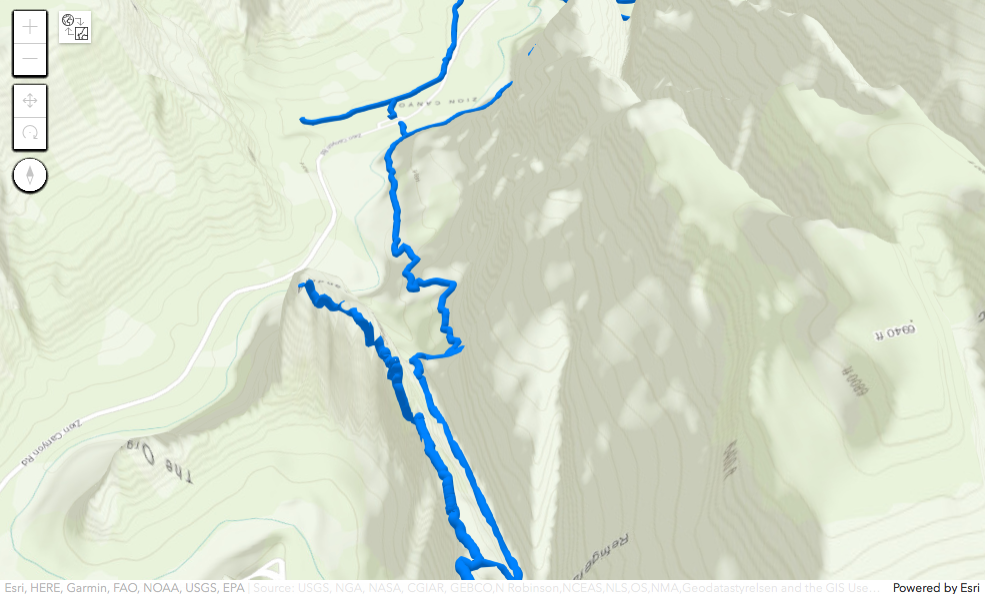

In [15]:
from arcgis.gis import GIS
zion_map = gis.map("Angel's Landing UT", 15)
zion_map.mode = "3D"
zion_map.tilt= 40
zion_map.heading = 180

zion_map

You can also add Portal items and layers to the 3D map just like before. Run the below cell to add a layer of trails: notice how the trails follow the elevation changes of the land!

In [21]:
trails_layer = gis.content.get('dd0889d7ccd340dd876dac12184e99f9').layers[0]
zion_map.add_layer(trails_layer)

The Python API also supports specifying Javascript renderers via [autocasting](https://developers.arcgis.com/javascript/latest/guide/autocasting/index.html). This Python API displays maps in a Jupyter notebook by leveraging the ArcGIS API for JavaScript. By specifying `renderer: "autocast"` for any renderer, you are directing Python to allow the Javascript API to attempt to infer the renderer by following Javascript API rules. Since Python `dict`'s map directly to JavaScript `JSON`, you can specify any [Javascript Renderer](https://developers.arcgis.com/javascript/latest/api-reference/esri-renderers-Renderer.html) for a large range of visualization options! Try running the below code snippet to use a `SimpleRenderer` with a `LineSymbol3D` symbol. More on autocast renderers below.

In [22]:
symbol = {
  "type": "line-3d",  # JS type of new LineSymbol3D()
  "symbolLayers": [{
    "type": "path",  # JS type of new PathSymbol3DLayer()
    "size": 20,  # 20 meters in diameter
    "material": { "color": "#0083ff" } #The hex color code
  }]
}
zion_map.add_layer(trails_layer,
    {"renderer" : "autocast", #Tell Python to autocast JS types
     "type" : "simple",  #JS type of SimpleRenderer()
     "symbol": symbol}   #The symbol we previously defined
)

You will notice a much more 3D friendly representation of trails! You can then specify some properties to propery visualize the "Angel's Landing" hike in Zion, one of the most dangerous and exciting hikes in the US! Run the below cell:

In [23]:
zion_map.center = {'spatialReference': {'latestWkid': 3857, 'wkid': 102100},
 'x': -12573456.64044217,
 'y': 4476861.2153126905,
 'z': 1638.3878966225311}
zion_map.zoom= 15.528381436708822
zion_map.heading = 190
zion_map.tilt = 45

You can save your current work as a WebScene by calling map.save(). Run the following code to save your WebScene!


In [ ]:
my_zion_webscene_item = \
    zion_map.save({'title' : 'My Zion Park Web Scene',
                   'snippet' : 'What I made in the new beta ArcGIS API for Python!',
                   'tags' : 'zion, NPS, python'})
my_zion_webscene_item

# Taking advantage of Autocasting

You are only limitted in your visualization options by the Javascript API: you can specify any renderer and modify any properties of said renderer. To show how poewrful this really is, let's use the SimpleRenderer's [visual variables](https://developers.arcgis.com/javascript/latest/api-reference/esri-renderers-SimpleRenderer.html#visualVariables) functionality. Run the below cell to see a standard Feature Layer about Hurricane tracks in 2D mode.


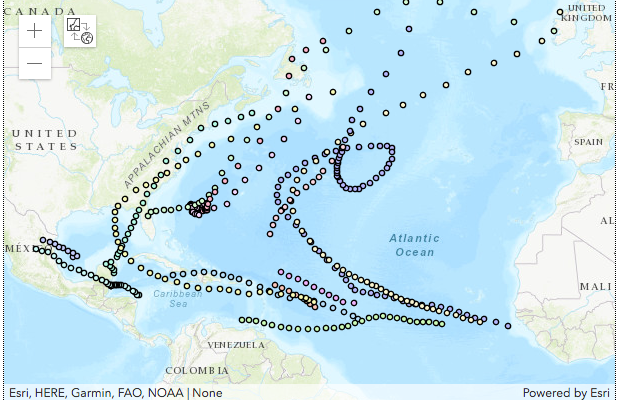

In [20]:
from arcgis.gis import GIS
from arcgis.features import FeatureLayer
anon_gis = GIS()
hurricane_layer = FeatureLayer(
    url="https://sampleserver6.arcgisonline.com/arcgis/rest/services/Hurricanes/MapServer/0")
hurricane_map = anon_gis.map('Atlantic Ocean', 3)
hurricane_map.add_layer(hurricane_layer)
hurricane_map

You can represent this same information on a 3D map by specifying a SimpleRenderer using white spheres. Run the below cell, click on some points, and examine some fields:


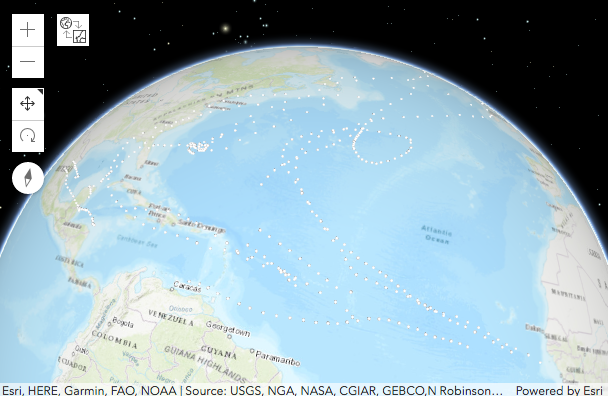

In [22]:
hurricane_map_3D = anon_gis.map('Atlantic Ocean', 3)
hurricane_map_3D.mode = "3D"
renderer = {"renderer": "autocast", #This tells python to use JS autocasting
  "type": "simple",  # JS type of new SimpleRenderer()
  "symbol": {
    "type": "point-3d",  #JS type of new PointSymbol3D()
    "symbolLayers": [{  
      "type": "object",  #JS type of new ObjectSymbol3DLayer()
      "resource": { "primitive": "sphere" },
      "width": 50000
    }]
  },
}

hurricane_map_3D.add_layer(hurricane_layer, renderer)
hurricane_map_3D

Now that we have the base set up, lets specify the `visualVariables` field to vary the color of each point for the changing `PRESSURE` field, and vary the size of each point for the changing `WINDSPEED` field. Run the below cell, then try modifying the options to see different results! Maybe try tuning the `"value"` fields to see different color and size variations.


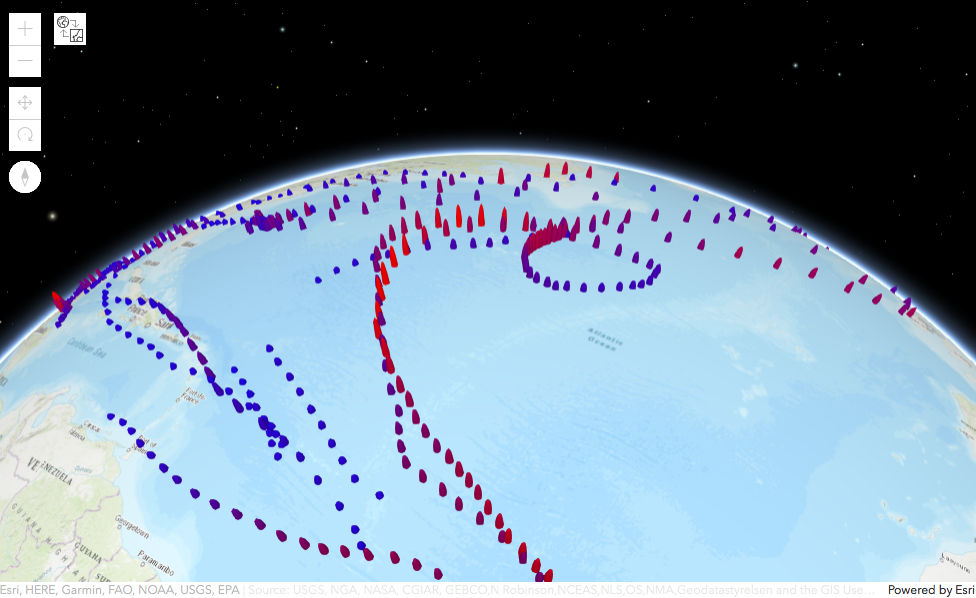

In [17]:
visual_var_map = anon_gis.map('Atlantic Ocean', 3)
visual_var_map.mode = "3D"
#Update the renderer to include visual variable information
renderer["visualVariables"] = [{ #JS configuration of visualVariables
    "type": "color",
    "field": "PRESSURE", 
    "stops": [
      { "value": 950, "color": "red" },
      { "value": 1020, "color": "blue" }
    ]
  }, {
    "type": "size",
    "field": "WINDSPEED",
    "stops": [
      { "value": 20, "size": 60000 },
      { "value": 150, "size": 500000 }
    ],
    "axis": "height"
  }, {
    "type": "size",
    "axis": "width-and-depth",
    "useSymbolValue": True
  }]
visual_var_map.add_layer(hurricane_layer, renderer)
visual_var_map

## Export to HTML

Another new feature in 1.5.0 is the ability to export the current widget as a standalone HTML file. This added functionality provides a new workflow for creating standalone HTML maps that can be shared with anyone: all they need is a web browser!

The below cell will write the current widget to the file specified by a string path. Run the cell, find the file on your disk, and open it in your favorite web browser.

> Note: By default, only publically accesible layers will show on the exported HTML maps. You must specify credentials_prompt=True to allow users to authenticate to portal to view private layers. See [the API reference](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.widgets.html#arcgis.widgets.MapView.export_to_html) for more information.

In [ ]:
import os

file_dir = os.path.join(os.getcwd(), 'home')
if not os.path.isdir(file_dir):
    os.mkdir(file_dir)
    
file_path = os.path.join(file_dir, 'myHurricaneMap.html')

visual_var_map.export_to_html(file_path)
print("html saved as " + file_path) # On Windows, path can be 'C:\Users\Username\Documents\home\myHurricaneMap.html'